# Project Instructions
- Load the data.
- Check that the data is free of issues — there is no missing data, extreme values, and so on.
- Work on each task and answer the questions posed in the project template.
- Draw conclusions based on your experience working on the project.

There is some precode in the project template, feel free to use it, some precode needs to be finished first. Also, there are two appendices in the project template with useful information.

- Task 1: Find customers who are similar to a given customer. This will help the company's agents with marketing.
- Task 2: Predict whether a new customer is likely to receive an insurance benefit.
- Task 3: Predict the number of insurance benefits a new customer is likely to receive using a linear regression model.
- Task 4: Protect clients' personal data without breaking the model from the previous task.

### Data Description

- Features: insured person's gender, age, salary, and number of family members.
- Target: number of insurance benefits received by an insured person over the last five years.

### Step 1. Load and Prepare our data

In [1]:
#Import our packages

import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')
import plotly.io as pio
pio.renderers.default = "svg"
import seaborn as sns
import sklearn.neighbors

from matplotlib import pyplot as plt
from sklearn.preprocessing import OneHotEncoder ,StandardScaler, MaxAbsScaler
from sklearn.base import BaseEstimator,TransformerMixin
from sklearn.impute import SimpleImputer
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, roc_auc_score,r2_score,mean_squared_error
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, train_test_split
from scipy.spatial import distance

In [2]:
#load our data set
try:
    insurance = pd.read_csv('insurance_us.csv')
    display(insurance.sample(5))
    display(insurance.info())
except:
    print('Something go wrong')

,Gender,Age,Salary,Family members,Insurance benefits
1598,0,28.0,39800.0,1,0
1652,0,26.0,52800.0,3,0
2567,0,47.0,32800.0,0,1
2962,1,41.0,41100.0,2,0
920,1,34.0,22500.0,0,0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Gender              5000 non-null   int64  
 1   Age                 5000 non-null   float64
 2   Salary              5000 non-null   float64
 3   Family members      5000 non-null   int64  
 4   Insurance benefits  5000 non-null   int64  
dtypes: float64(2), int64(3)
memory usage: 195.4 KB


None

In [3]:
#Checking for missing values
insurance.isnull().sum()

Gender                0
Age                   0
Salary                0
Family members        0
Insurance benefits    0
dtype: int64

In [4]:
#Changin type of our "Age" column
insurance['Age'] = insurance['Age'].astype('int')
insurance.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 5 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Gender              5000 non-null   int64  
 1   Age                 5000 non-null   int32  
 2   Salary              5000 non-null   float64
 3   Family members      5000 non-null   int64  
 4   Insurance benefits  5000 non-null   int64  
dtypes: float64(1), int32(1), int64(3)
memory usage: 175.9 KB


In [5]:
#Looking for duplicates
insurance.duplicated().sum()

153

> **Conclusion:** From all previous operations, we can say that we have precise data set with a small number of duplicates, but I propose to leave them because we don't for sure if is it a mess or unique customers with similar parameters

### Step 2. Providing EDA

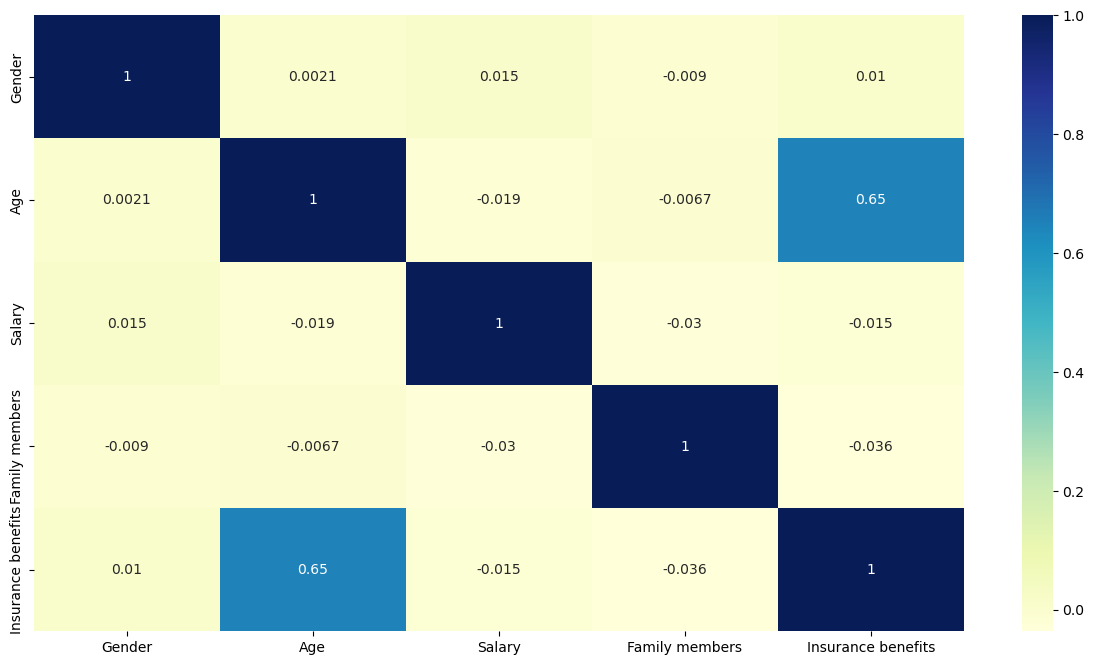

In [6]:
#Let's find out what kind of corraletion we have in our data
plt.figure(figsize=(15,8))
sns.heatmap(insurance.corr(),annot=True, cmap='YlGnBu');

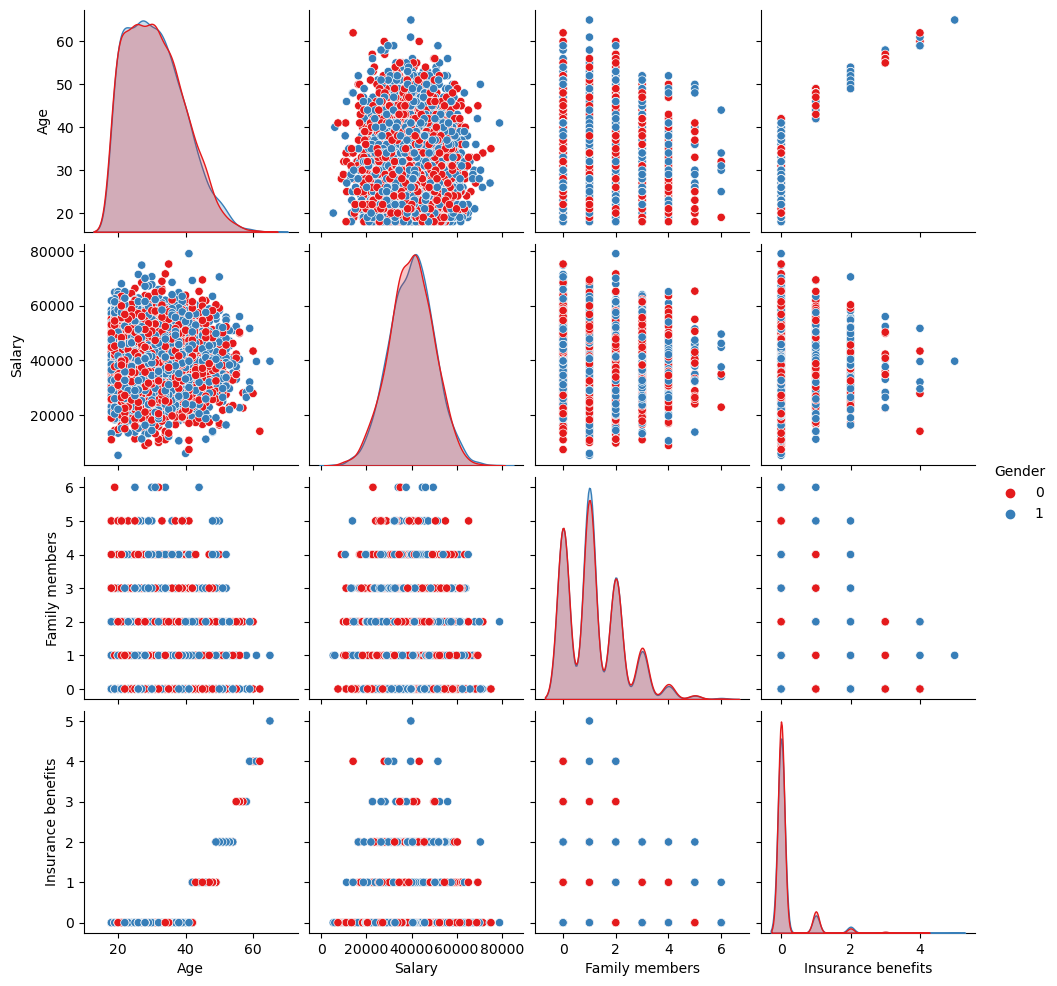

In [7]:
#How our variables depend on each other
sns.pairplot(insurance, hue='Gender', palette='Set1');

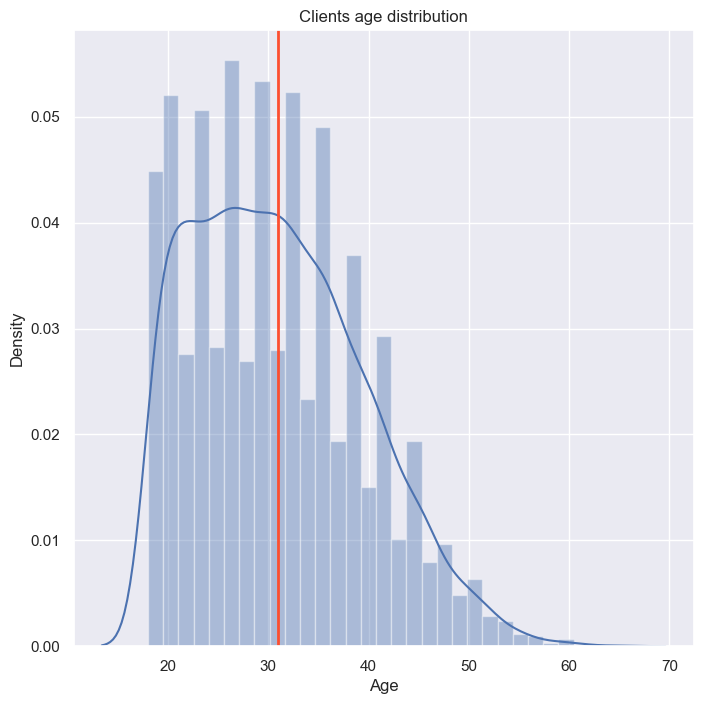

In [8]:
#Ploting our age distribution
mean = insurance['Age'].mean()
color = "#fc4f30"
sns.set()
plt.figure(figsize=(8,8))
sns.distplot(insurance['Age'])
plt.axvline(mean, color=color, label="Mean_age", linewidth=2)
plt.title('Clients age distribution')
plt.show()

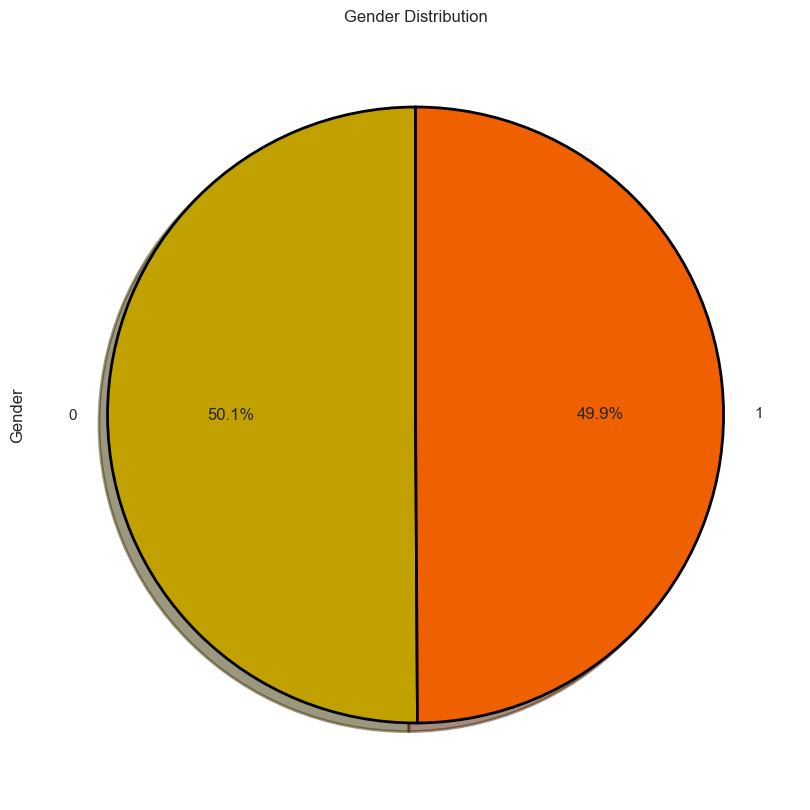

In [10]:
#Creating a pie chart to show what kind of gender distribution we have in our data 
#0 - Male
#1 - Female

colors = ['#c0a100','#ee6000']
insurance['Gender'].value_counts().plot.pie( shadow = True, colors = colors, startangle = 90,
                                                         wedgeprops = {"edgecolor" : "black",'linewidth': 2,
                                                                       'antialiased': True},
                                                         autopct='%1.1f%%',figsize=(10,10),title= "Gender Distribution");

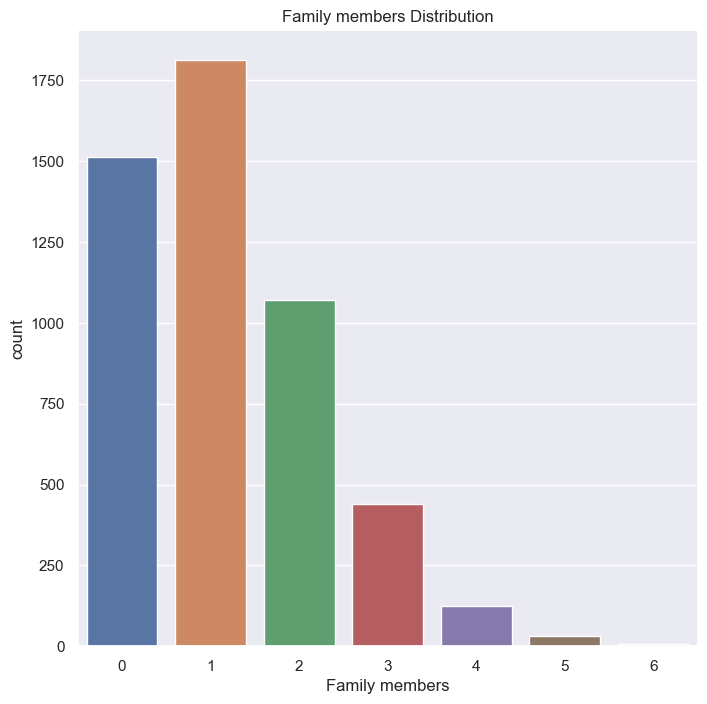

In [11]:
#Family members 
plt.figure(figsize=(8,8))
sns.countplot(x='Family members',data=insurance)
plt.title('Family members Distribution')
plt.show()

In [12]:
#Creating function that will plot boxplot with necessary information
def boxplot(data,column,target):
    plt.style.use("seaborn-deep")
    fig, axs = plt.subplots(1, 1, figsize=(8,8) )
    sns.boxplot(data=data, x=column, y=target, hue='Gender',palette='tab10',medianprops={"color": "coral"}, showfliers=False, ax=axs)
    axs.set_xlabel(column, fontsize=14)
    plt.show()
    


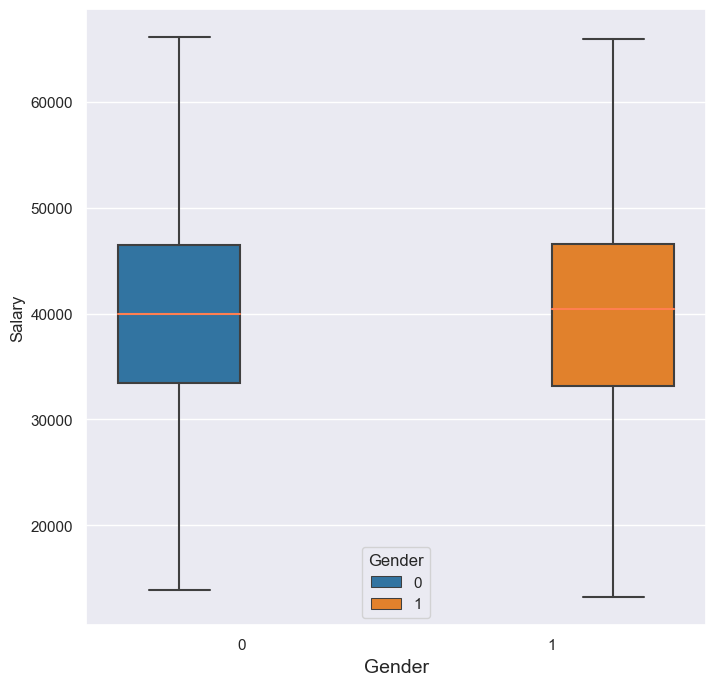

In [13]:
#0 - male
#1- female
boxplot(insurance,'Gender','Salary')

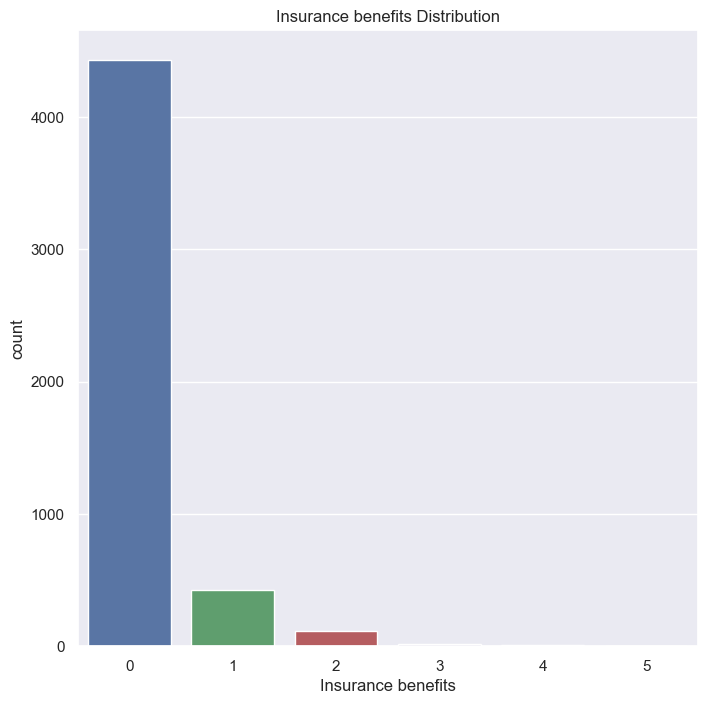

In [14]:
#Insurance distribution between our clients 
plt.figure(figsize=(8,8))
sns.countplot(x='Insurance benefits',data=insurance)
plt.title('Insurance benefits Distribution')
plt.show()

> **Conclusion:** After our EDA we can say that our Insurance benefits strongly depend on the Age of our client, and most of our clients lie in the age range between **20-40**. From our Bopxplot we can see that we have likely identical salary distribution between male and female gender, and in the end from our last countplot, we see that most of our clients don't have any insurance benefits.

### Step 3. Find customers who are similar to the given customer. This will help the company's agents with marketing.

- The best way to find similarities between customers in this step it's two find **Euclidean** and **Manhattan** distances between them. But first, we must scale our data so that we will have a similar range between our variables which will provide better work of our method

In [15]:
#Creating our function that will show us our neiborhoods that locate near target value
def sim_cus(data,targ, num, metric):
    #First calling our algorithm
    #Than Training 
    #Finding the nearest neighborhoods and assigning them to new variables
    #Concate our data set with a new variable by using neighborhood indices
    
    nbrs = sklearn.neighbors.NearestNeighbors(metric=metric)
    nbrs.fit(data[feature_nn])
    nbrs_distances, nbrs_indices = nbrs.kneighbors([data.iloc[targ][feature_nn]], num, return_distance=True)
    
    data_res = pd.concat([
        data.iloc[nbrs_indices[0]], 
        pd.DataFrame(nbrs_distances.T, index=nbrs_indices[0], columns=['distance'])
        ], axis=1)
    
    return data_res

In [16]:
#columns need to be scaled
feature_nn = ['Gender','Age','Salary','Family members']

#fit the scaler
transformer_mas = MaxAbsScaler().fit(insurance[feature_nn].to_numpy())

#apply the scaler
insurance_scaled = insurance.copy()
insurance_scaled.loc[:, feature_nn] = transformer_mas.transform(insurance[feature_nn].to_numpy())

In [17]:
# Use Euclidean distance with the scaled data and find 10 nearest neighbors for the 1st row
sim_cus(insurance_scaled[feature_nn], 0, 10, 'euclidean')

,Gender,Age,Salary,Family members,distance
0,1.0,0.630769,0.627848,0.166667,0.000000
2689,1.0,0.630769,0.634177,0.166667,0.006329
133,1.0,0.615385,0.636709,0.166667,0.017754
4869,1.0,0.646154,0.637975,0.166667,0.018418
3275,1.0,0.646154,0.651899,0.166667,0.028550
1567,1.0,0.615385,0.602532,0.166667,0.029624
3365,1.0,0.630769,0.596203,0.166667,0.031646
2103,1.0,0.630769,0.596203,0.166667,0.031646
124,1.0,0.661538,0.635443,0.166667,0.031693
3636,1.0,0.615385,0.600000,0.166667,0.031815


In [18]:
# Use Manhattan (city block) distance with the scaled data and find 10 nearest neighbors for the 1st row
sim_cus(insurance_scaled[feature_nn], 0, 10, 'manhattan')

,Gender,Age,Salary,Family members,distance
0,1.0,0.630769,0.627848,0.166667,0.000000
2689,1.0,0.630769,0.634177,0.166667,0.006329
133,1.0,0.615385,0.636709,0.166667,0.024245
4869,1.0,0.646154,0.637975,0.166667,0.025511
3365,1.0,0.630769,0.596203,0.166667,0.031646
2103,1.0,0.630769,0.596203,0.166667,0.031646
124,1.0,0.661538,0.635443,0.166667,0.038364
4305,1.0,0.630769,0.588608,0.166667,0.039241
3275,1.0,0.646154,0.651899,0.166667,0.039435
1567,1.0,0.615385,0.602532,0.166667,0.040701


### Step 4. Predict whether a new customer is likely to receive an insurance benefit.
- In this step, we will work with our data set first to solve some oversampling problem and scaling problems and only then we can start working with our classifier

- Here I propose to create a new column with ppl who will take benefits and who not this will be our target variable for our next move to find out whether or not the next client will receive an insurance benefit

In [19]:
assign a new function that will help us take all clients who took insurance benefits
def new_var(data):
    ins_ben = data['Insurance benefits']
    if  ins_ben > 0:
        return 1
    return 0
insurance['Target'] = insurance.apply(new_var,axis=1)
insurance['Target'].value_counts()

0    4436
1     564
Name: Target, dtype: int64

- But before we start working with our model we must provide our data set with equal numbers of **0**, and **1** or we would have oversampling or undersampling problems

In [20]:
#Making our "Majority" class equal to the "Minority" by using the Undersampling method
ds_class_0 = insurance[insurance['Target'] == 0]
ds_class_1 = insurance[insurance['Target'] == 1]

count_class_0,count_class_1 = insurance.Target.value_counts()
ds_class_1_upd = ds_class_1.sample(count_class_0,replace= True)


insurance_upd = pd.concat([ds_class_1_upd,ds_class_0],axis=0)
insurance_upd.Target.value_counts()

1    4436
0    4436
Name: Target, dtype: int64

- Now that we have an equal number of our Target values let's move on and start working with our model. First, we will create our **Target** and **Features** variable and then we need to provide scaling to our data to make our model watch on features equally and not take into account their distribution range


In [21]:
#Our necessary variables
features = insurance_upd.drop(['Insurance benefits','Target'],axis=1)
target = insurance_upd['Target']

#Creating scaler 
scaler =  MaxAbsScaler()




features_train, features_valid, target_train, target_valid = train_test_split(
    features, target, test_size=0.25, random_state=12345
)

X_train = scaler.fit_transform(features_train)
X_valid = scaler.fit_transform(features_valid)

y_train = target_train.to_numpy()
y_valid = target_valid.to_numpy()

print(X_train.shape)
print(y_train.shape)
print()
print(X_valid.shape)
print(y_valid.shape)

(6654, 4)
(6654,)

(2218, 4)
(2218,)


In [22]:
#applying our model, first let's work with RandomForest algor
clf = RandomForestClassifier()
param_grid = [{"n_estimators":[10,100,200,500],
              "max_depth":[None,5,10],
              "min_samples_split":[2,3,4]}]
grid_search = GridSearchCV(clf,param_grid,cv = 3)
grid_search.fit(X_train,y_train)

GridSearchCV(cv=3, estimator=RandomForestClassifier(),
             param_grid=[{'max_depth': [None, 5, 10],
                          'min_samples_split': [2, 3, 4],
                          'n_estimators': [10, 100, 200, 500]}])

In [23]:
#best hyperparameters for our model
final_clf = grid_search.best_estimator_
final_clf

RandomForestClassifier(n_estimators=10)

In [24]:
#let's start working with our model
final_model = RandomForestClassifier(random_state=54321,n_estimators=10)
final_model.fit(X_train,y_train)
predic_forest = final_model.predict(X_valid)
print(classification_report(y_valid,predic_forest))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1130
           1       1.00      1.00      1.00      1088

    accuracy                           1.00      2218
   macro avg       1.00      1.00      1.00      2218
weighted avg       1.00      1.00      1.00      2218



Confusion Matrix


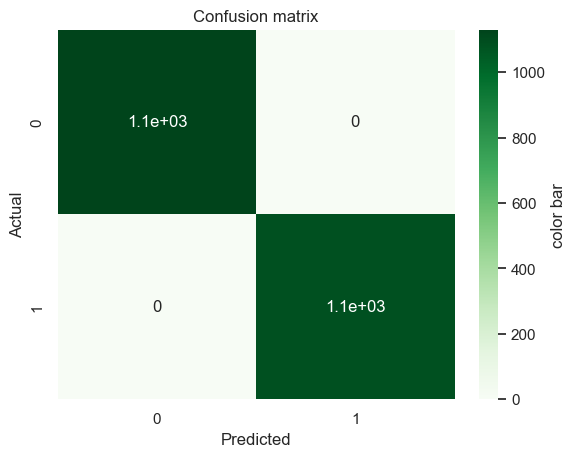

In [25]:
#plotting confusion matrix
def conf_matrix(y_valid,predict):
    cm = confusion_matrix(y_valid,predict,labels=[0,1])
    print('Confusion Matrix')
    sns.heatmap(cm,cmap='Greens',annot = True,
               cbar_kws = {"orientation":"vertical",
                          "label":"color bar"},
               xticklabels = [0,1],yticklabels=[0,1])
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion matrix")
    plt.show()
    
conf_matrix(y_valid,predic_forest)

>**Conclusion:** Seems we have 100% accuracy seems impossible but we have what we have let's move on

### Step 4. Predict the number of insurance benefits a new customer is likely to receive using a Linear Regression model.
- In this task  we will use our main data to which we didnt provide oversampling solution

In [29]:
#Starting working with our Linear Regression algorithm 


features_m = insurance.drop(['Insurance benefits','Target'],axis=1)
target_m = insurance['Insurance benefits']


X_train_m, X_valid_m, y_train_m, y_valid_m = train_test_split(features_m, target_m, test_size=0.25,random_state=12345)

#scaler our sets
scaler_m = StandardScaler()

X_train_ms = scaler_m.fit_transform(X_train_m)
X_valid_ms = scaler_m.fit_transform(X_valid_m)


y_train_m = y_train_m.to_numpy()
y_valid_m = y_valid_m.to_numpy()


print(X_train_ms.shape)
print(X_valid_ms.shape)
print(y_train_m.shape)
print(y_valid_m.shape)

(3750, 4)
(1250, 4)
(3750,)
(1250,)


In [30]:
#Creating our hand made LinearRegression model by using **class** method
class LinearRegression_t:
    def fit(self, train_features, train_target):
        X = np.concatenate((np.ones((train_features.shape[0], 1)), train_features), axis=1)# add column to matrix whit 1 values
        y = train_target
        w = (np.linalg.inv(X.T.dot(X)).dot(X.T)).dot(y)# calculate "w"
        self.w = w[1:]# taking our w values from the second column
        self.w0 = w[0]# taking all w values equal to "1"

    def predict(self, test_features):
        return test_features.dot(self.w) + self.w0
    
model = LinearRegression_t()
model.fit(X_train_ms, y_train_m)
predictions = model.predict(X_valid_ms)
print(r2_score(y_valid_m, predictions))

0.43548815291893317


In [31]:

#fetching our model from sklearn library
model_liner = LinearRegression()
#Finding predictions values for main set
model_m = model_liner.fit(X_train_ms,y_train_m)

predic_m = model_m.predict(X_valid_ms)
print(r2_score(y_valid_m, predic_m))
print(mean_squared_error(y_valid_m, predic_m))


0.4354881529189333
0.11655137399574535


Coefficients:  [ 0.00896098  0.30200391 -0.00539004 -0.01380187]

Variance score: 0.4354881529189333


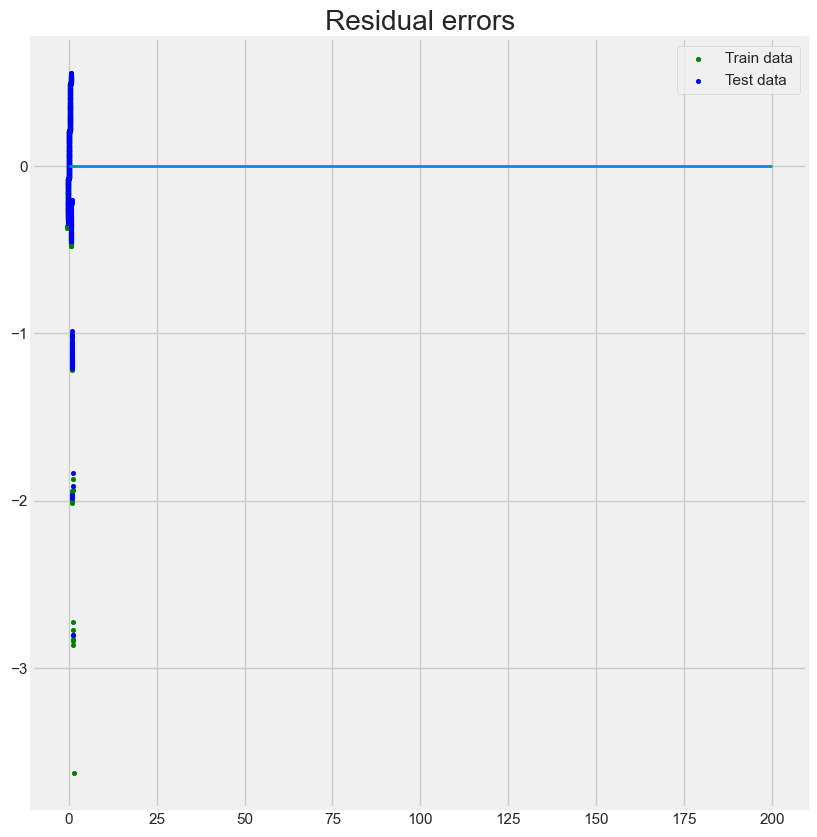

In [32]:
# regression coefficients
print('Coefficients: ', model_m.coef_)
print()
# variance score: 1 means perfect prediction
print('Variance score: {}'.format(model_m.score(X_valid_ms, y_valid_m)))
 
# plot for residual error
plt.figure(figsize=(10,10))
# setting plot style
plt.style.use('fivethirtyeight')
 
# plotting residual errors in training data
plt.scatter(model_m.predict(X_train_ms),
            model_m.predict(X_train_ms) - y_train_m,
            color="green", s=10,
            label='Train data')
 
# plotting residual errors in test data
plt.scatter(model_m.predict(X_valid_ms),
            model_m.predict(X_valid_ms) - y_valid_m,
            color="blue", s=10,
            label='Test data')
 
# plotting line for zero residual error
plt.hlines(y=0, xmin=0, xmax=200, linewidth=2)
 
# plotting legend
plt.legend(loc='upper right')
 
# plot title
plt.title("Residual errors")
 
# method call for showing the plot
plt.show()

> **Conclusion**: From the previous step, we see that by working with a hand-made algorithm and by using the same one but from the sklearn library we have the same result that we achieved from calculating metrics.

### Step 5: Develop a way to protect clients' personal data without affecting the model from the previous task.

In this step we will use **Obfuscating Data** method 

In [33]:
data_obf = insurance[feature_nn].to_numpy()
data_obf 

array([[1.00e+00, 4.10e+01, 4.96e+04, 1.00e+00],
       [0.00e+00, 4.60e+01, 3.80e+04, 1.00e+00],
       [0.00e+00, 2.90e+01, 2.10e+04, 0.00e+00],
       ...,
       [0.00e+00, 2.00e+01, 3.39e+04, 2.00e+00],
       [1.00e+00, 2.20e+01, 3.27e+04, 3.00e+00],
       [1.00e+00, 2.80e+01, 4.06e+04, 1.00e+00]])

In [34]:
#Creating a random matrix
rand_m = np.random.default_rng(seed=42)
p = rand_m.random(size=(data_obf.shape[1], data_obf.shape[1]))
p

array([[0.77395605, 0.43887844, 0.85859792, 0.69736803],
       [0.09417735, 0.97562235, 0.7611397 , 0.78606431],
       [0.12811363, 0.45038594, 0.37079802, 0.92676499],
       [0.64386512, 0.82276161, 0.4434142 , 0.22723872]])

In [35]:
#now we will multiple our two matrix
data_dot = data_obf.dot(p)
data_dot 

array([[ 6359.71527314, 22380.40467609, 18424.09074184, 46000.69669016],
       [ 4873.29406479, 17160.36702982, 14125.78076133, 35253.45577301],
       [ 2693.11742928,  9486.397744  ,  7808.83156024, 19484.86063067],
       ...,
       [ 4346.2234249 , 15289.24126492, 12586.16264392, 31433.50888552],
       [ 4194.09324155, 14751.9910242 , 12144.02930637, 30323.88763426],
       [ 5205.46827354, 18314.24814446, 15077.01370762, 37649.59295455]])

In [36]:
#now let's provide inversion to our random P matrix
p_inv = np.linalg.inv(p)
p_inv 

array([[ 0.41467992, -1.43783972,  0.62798546,  1.14001268],
       [-1.06101789,  0.44219337,  0.1329549 ,  1.18425933],
       [ 1.42362442,  1.60461607, -2.0553823 , -1.53699695],
       [-0.11128575, -0.65813802,  1.74995517, -0.11816316]])

In [37]:
#The final result of our obfuscating is 
data_r = data_dot.dot(p_inv)

- Now we need to check if our model will work in exact same way as it did before after we provided all our obfuscating procedures

In [38]:
#New features and target variables
x_test = insurance[feature_nn].to_numpy()
y_test = insurance['Insurance benefits'].to_numpy()



In [39]:
#Now let's obfus our data
X_test_dot = x_test.dot(p)

X_train_d,X_valid_d,y_train_d,y_valid_d = train_test_split(X_test_dot,y_test, test_size=0.25, random_state=12345)

lr_test = LinearRegression()
lr_test.fit(X_train_d, y_train_d)
predict_test = lr_test.predict(X_valid_d)

print(r2_score(y_valid_d, predict_test))
print(mean_squared_error(y_valid_d, predict_test))

0.43522757127024836
0.11660517472525944


> **Conclusion:** As we see we have the same result,  by calculating our score metrics using obfuscated data sets, we prove that by using the obfuscating method we don't provide a negative effect on our model.

# Overal Conclusion:
- At the beginning of our project, we imported all of our necessary packages and then we loaded our data set where we had 5000 rows and 5 columns. Due to preparation, we change the type of one of our columns and then saw that we didn't have any missing values.
- Then we did EDA to obtain a clear picture of what we had inside our features.
- To find similar customers, a model has been developed. This model found similar customers to provided customers. Here, it was observed that scaling of data is very important to find correct similar customers.
- To Predict whether a new customer is likely to receive an insurance benefit we chose the RandomForest model with the help of our GridSearch method we found the better hyperparameter to ouf model.
- By using the LinearRegresion algorithm we created a model which predicted exactly how many insurance benefits would a customer utilize. The developed model has not been affected by data scaling. As a result developed model has RMSE and R2 scores of 0.43 and RMSE 0.11, respectively.
- And in the last to protect the sensitive personal information of customers, a data masking (data obfuscation) strategy has been developed and the correctness of the strategy has been proved mathematically. Then the developed strategy has been tested, whether it will affect the model performance or not. As a result, it was observed that model quality was resistant to the developed data obfuscation strategy.